In [1]:
%matplotlib inline
import rasterio as rio
from rasterio import features
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import pandas as pd
from datetime import datetime
from shapely.geometry import shape
import geopandas as gpd

sys.path.append(os.path.join(os.path.abspath(''), "../"))
from src import get_affine, get_metadata, vectorize_raster

In [2]:
target_date = [
    datetime.strptime("20200101", "%Y%m%d"),
    datetime.strptime("20201231", "%Y%m%d")
]

data_root = os.path.join("..", "data", "Karachi")
flist = glob.glob(os.path.join(data_root, "*"))

filtered_flist = []
for fname in flist:
    dt = get_metadata(fname)["date"]
    if dt > target_date[0] and dt < target_date[1]:
        filtered_flist.append(fname)


['../data/Karachi/S1A_IW_GRDH_1SDV_20201117T133533_20201117T133558_035289_041F31_BB51.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200521T133526_20200521T133551_032664_03C87C_B1EE.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200509T133526_20200509T133551_032489_03C333_EB00.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20201211T133532_20201211T133557_035639_042B39_477B.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20201129T133533_20201129T133558_035464_042538_B971.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200427T133525_20200427T133550_032314_03BD48_B947.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200227T133523_20200227T133548_031439_039E97_D981.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200906T133533_20200906T133558_034239_03FA87_44F8.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200602T133527_20200602T133552_032839_03CDBE_C5EB.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20201223T133532_20201223T133557_035814_043143_C3F4.tif',
 '../data/Karachi/S1A_IW_GRDH_1SDV_20200918T133533_20200918T133558_034414_0400AD

In [3]:
month_list = [get_metadata(fname)["date"].month for fname in filtered_flist]
datetime_list = [get_metadata(fname)["date"] for fname in filtered_flist]

master_df = pd.DataFrame({
    "fname": filtered_flist,
    "month": month_list,
    "datetime": datetime_list
})

master_df.head()

fname  month  \
0  ../data/Karachi/S1A_IW_GRDH_1SDV_20201117T1335...     11   
1  ../data/Karachi/S1A_IW_GRDH_1SDV_20200521T1335...      5   
2  ../data/Karachi/S1A_IW_GRDH_1SDV_20200509T1335...      5   
3  ../data/Karachi/S1A_IW_GRDH_1SDV_20201211T1335...     12   
4  ../data/Karachi/S1A_IW_GRDH_1SDV_20201129T1335...     11   

             datetime  
0 2020-11-17 13:35:33  
1 2020-05-21 13:35:26  
2 2020-05-09 13:35:26  
3 2020-12-11 13:35:32  
4 2020-11-29 13:35:33

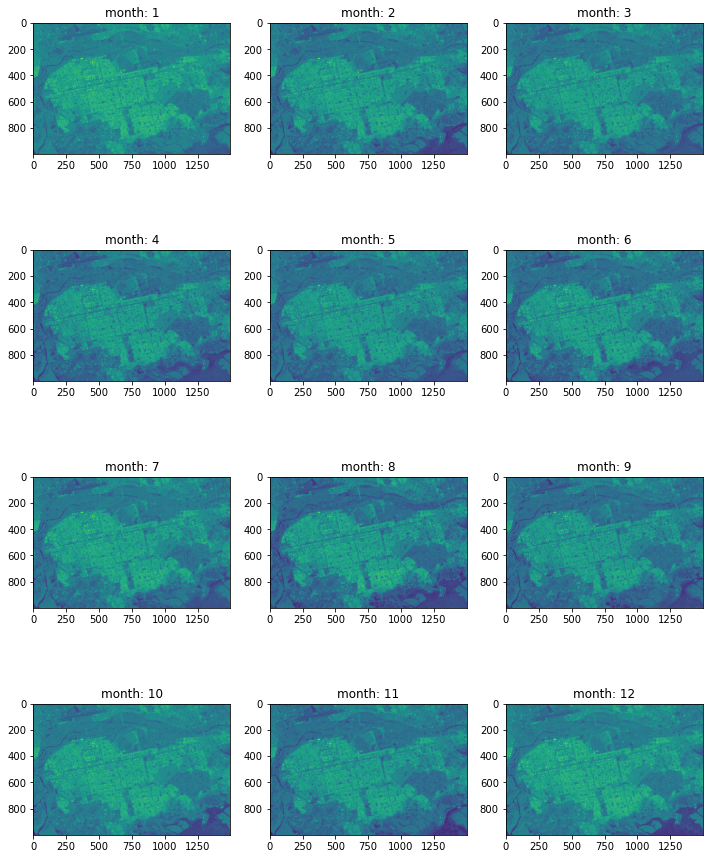

In [4]:
m = master_df["month"].unique()
m.sort()

x = [1000, 2000]
y = [2000, 3500]

VV_imgs = []

fig = plt.figure(figsize=(12, 16))

for i in m:
    img_mean = np.zeros((x[1] - x[0], y[1] - y[0]))
    m_i_list = list(master_df[master_df["month"] == i]["fname"])
    for img in m_i_list:
        with rio.open(img) as src:
            VV = src.read(1)
        img_mean += VV[x[0]:x[1], y[0]:y[1]]
    img_mean = img_mean/len(m_i_list)
    VV_imgs.append(img_mean)

    ax = plt.subplot(4, 3, i)
    ax.set_title(f"month: {i}")
    ax.imshow(img_mean)

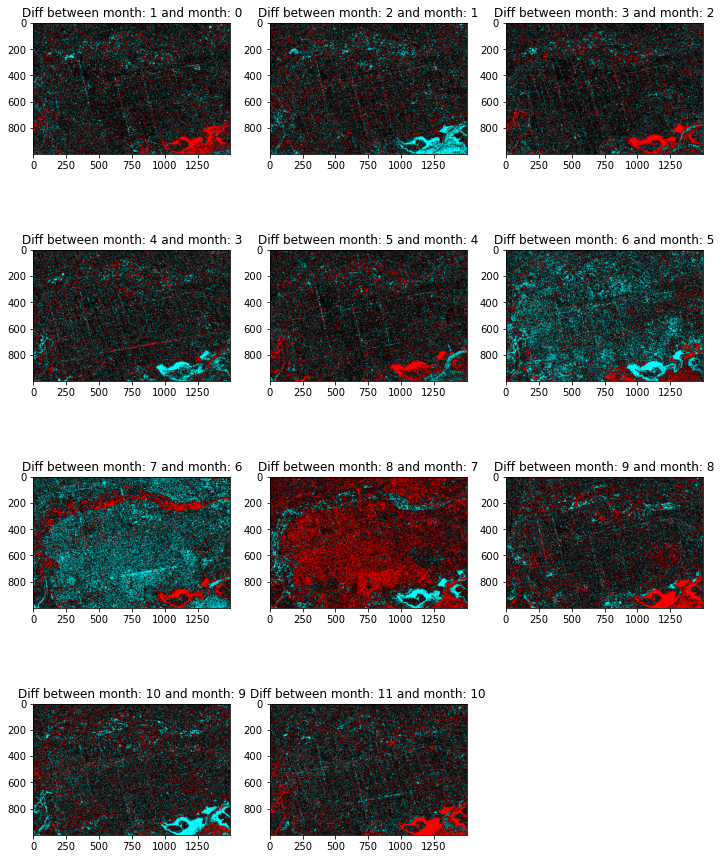

In [5]:
thresh = 2

fig = plt.figure(figsize=(12, 16))

for i in range(len(VV_imgs)):
    if i != 0:
        diff = VV_imgs[i] - VV_imgs[i-1]
        removed = np.where(diff < -thresh, 1, 0)
        constructed = np.where(diff > thresh, 1, 0)

        ax = plt.subplot(4, 3, i)
        ax.set_title(f"Diff between month: {i} and month: {i-1}")
        ax.imshow(np.array([removed, constructed, constructed]).transpose(1, 2, 0)*255)

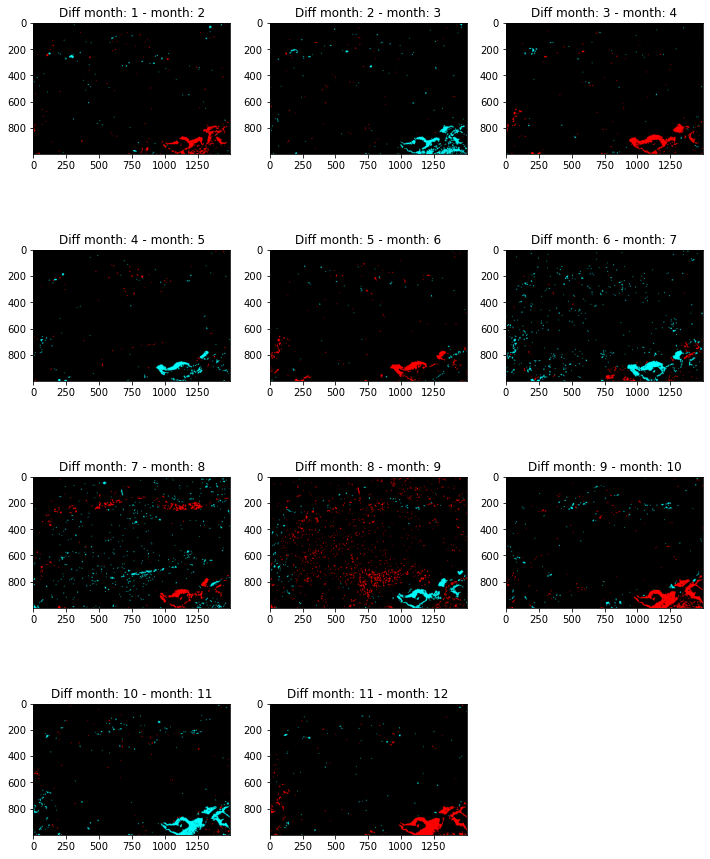

In [6]:
iteration = 2
kernel = np.ones((3, 3))
thresh = 2

fig = plt.figure(figsize=(12, 16))

for i in range(len(VV_imgs)):
    if i != 0:
        diff = VV_imgs[i] - VV_imgs[i-1]
        removed = np.where(diff < -thresh, 1, 0)
        constructed = np.where(diff > thresh, 1, 0)

        removed = cv2.erode(removed.astype("uint8"), kernel, iterations=iteration)
        removed = cv2.dilate(removed.astype("uint8"), kernel, iterations=iteration)
        constructed = cv2.erode(constructed.astype("uint8"), kernel, iterations=iteration)
        constructed = cv2.dilate(constructed.astype("uint8"), kernel, iterations=iteration)

        ax = plt.subplot(4, 3, i)
        ax.set_title(f"Diff month: {i} - month: {i+1}")
        ax.imshow(np.array([removed, constructed, constructed]).transpose(1, 2, 0)*255)

In [7]:
transform = get_affine(m_i_list[0], x, y)

In [12]:
iteration = 1
kernel = np.ones((3, 3))
thresh = 5
output_root = os.path.join("..", "output", "vector")
os.makedirs(output_root, exist_ok=True)

for i in range(len(VV_imgs)):
    if i != 0:
        diff = VV_imgs[i] - VV_imgs[i-1]
        removed = np.where(diff < -thresh, 2, 0)
        constructed = np.where(diff > thresh, 1, 0)

        removed = cv2.erode(removed.astype("uint8"), kernel, iterations=iteration)
        removed = cv2.dilate(removed.astype("uint8"), kernel, iterations=iteration)
        fname = os.path.join(output_root,
                             f"month{i}-month{i+1}_removed.geojson")
        gdf = vectorize_raster(removed, transform, src.crs)
        gdf.to_file(fname, driver="GeoJSON")

        constructed = cv2.erode(constructed.astype("uint8"), kernel, iterations=iteration)
        constructed = cv2.dilate(constructed.astype("uint8"), kernel, iterations=iteration)
        fname = os.path.join(output_root,
                             f"month{i}-month{i+1}_constructed.geojson")
        gdf = vectorize_raster(constructed, transform, src.crs)
        gdf.to_file(fname, driver="GeoJSON")

